## Import libraries

In [1]:
# OpenAI API
import openai

In [2]:
# insert OpenAI key
openai.api_key = ''

In [3]:
# Numpy - Pandas - Operating System
import numpy as np
import pandas as pd
import os

In [4]:
# Create lemanize function
from nltk import WordNetLemmatizer, PorterStemmer

In [6]:
# Natural language toolkit
import nltk

In [7]:
from nltk.corpus import stopwords

In [8]:
# Regular Expression
import re

In [9]:
# Time
import time

In [10]:
# Import PdfReader library
from PyPDF2 import PdfReader
# PlaintextCorpusReader class to create copus
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

In [11]:
#Gensim
import gensim
from gensim.utils import simple_preprocess

In [12]:
import gensim.corpora as corpora

## Count the tokens

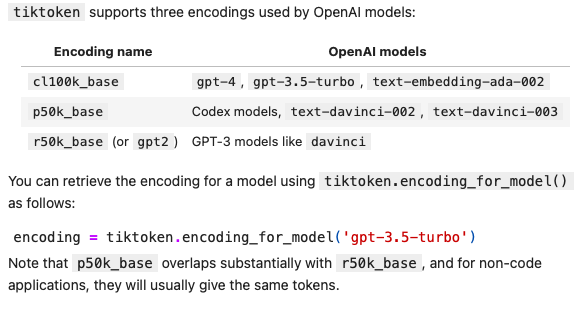

In [13]:
import tiktoken

In [14]:
# Download an encoding by name
encoding = tiktoken.get_encoding("cl100k_base")
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [16]:
# Function for counting the tokens
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

## Load TORD dataset

In [68]:
# Load csv file
df = pd.read_csv('/Users/hoangle/Documents/Milano-Bicocca_PhD/Data Analysis/TORD/tord_v3.csv', delimiter=';')

In [69]:
# Set new index (NewID) as ID gets disrupted at some points
df.index.names = ['NewID']

In [70]:
# Show all columns
pd.set_option('display.max_columns', None)

In [71]:
%%capture
# Create a dummy variable indicating whitepaper availability
df['WP']=0
i=0
while i<=6414:
    file_name="/Users/hoangle/Desktop/Whitepaper/"+df['name'].loc[i]+'.pdf'
    if os.path.exists(file_name):
        df['WP'].loc[i]=1
        print('Whitepaper: ',df['name'].loc[i],' available')
    i = i+1

## Inspect the data

In [72]:
# Count the available whitepaper
df['WP'].value_counts()

WP
0    5648
1     767
Name: count, dtype: int64

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6415 entries, 0 to 6414
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        6415 non-null   int64  
 1   name                      6415 non-null   object 
 2   token                     6282 non-null   object 
 3   country                   6415 non-null   object 
 4   is_ico                    6415 non-null   int64  
 5   is_ieo                    6415 non-null   int64  
 6   is_sto                    6415 non-null   int64  
 7   ico_start                 5636 non-null   object 
 8   ico_end                   5497 non-null   object 
 9   price_usd                 5928 non-null   object 
 10  raised_usd                2139 non-null   float64
 11  distributed_in_ico        4870 non-null   float64
 12  sold_tokens               192 non-null    float64
 13  token_for_sale            5122 non-null   float64
 14  whitelis

In [74]:
df['is_sto'].value_counts()

is_sto
0    6326
1      89
Name: count, dtype: int64

# Create dataset of observed whitepaper

In [39]:
df_only_wp = df[df['WP']==1]

In [41]:
df_only_wp = df_only_wp.reset_index().drop(['NewID','id'],axis=1)

## Create dataset of observed amount raised and whitepaper

In [29]:
df_wp = df[(df['WP']==1) & (df['raised_usd']>=0)]

In [27]:
df_wp = df_wp.reset_index().drop(['NewID','id'],axis=1)

### Classify fund raised into groups

In [12]:
# Create different group of fund raised
# Amount raised
# Q1 : [0 - $0.1]
# Q2 : ($0.1-$100.000]
# Q3 : ($100.000 - $1.000.000]
# Q4 : ($1.000.000 - $10.000.000]
# Q5 : ($10.000.000 - $100.000.000]
# Q6 : ($100.000.000 - $1.710.000.000]
bins1 = [0,0.1,1e+5,1e+6,1e+7,1e+8,1.71e+9]
labels1 = 'Q1,Q2,Q3,Q4,Q5,Q6'.split(',')

In [13]:
df['Quantile'] = pd.cut(x = df['raised_usd'], bins=bins1,
                        labels = labels1, include_lowest=True)

In [14]:
df['Quantile'].value_counts()

Q4    958
Q5    584
Q3    362
Q2    123
Q1     89
Q6     23
Name: Quantile, dtype: int64

In [85]:
df[df['Quantile']=='Q6']

,id,name,token,country,is_ico,is_ieo,is_sto,ico_start,ico_end,price_usd,raised_usd,distributed_in_ico,sold_tokens,token_for_sale,whitelist,kyc,bonus,restricted_areas,min_investment,bounty,mvp,pre_ico_start,pre_ico_end,pre_ico_price_usd,platform,accepting,link_white_paper,linkedin_link,github_link,website,rating,teamsize,Coinmarketcap_identifier,ERC20,WP,Quantile
NewID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
806,809,DFINITY,NaN,USA,1,0,0,2018-04-01,2018-08-29,NaN,1.950000e+08,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,https://www.linkedin.com/company/dfinity/,https://www.github.com/dfinity?tab=repositories,https://dfinity.org/?utm_source=icobench,2.8,22.0,5177.0,1.0,0,Q6
1365,1368,Algorand,NaN,USA,1,0,0,2019-06-19,2019-06-19,2.4,1.224000e+08,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,1,NaN,NaN,https://www.linkedin.com/company/algorand/,None,https://www.algorand.com/?utm_source=icobench,2.2,NaN,4030.0,1.0,0,Q6
1604,1609,Kinesis,KVT,Cayman Islands,1,0,0,2018-09-10,2019-09-07,1000,1.938720e+08,0.70,NaN,2.100000e+05,No,1,0,NaN,1 KVT,0,NaN,2018-02-14,2018-09-09,NaN,1,"BTC, ETH, Fiat",https://kinesis.money/documents/whitepaper.pdf,https://www.linkedin.com/company/kinesismoney/,https://www.github.com/KinesisNetwork?tab=repo...,https://kinesis.money/en/?utm_source=icobench,4.3,32.0,NaN,1.0,0,Q6
2501,2508,TaTaTu,TTU,Cayman Islands,1,0,0,2018-06-11,2018-06-30,0.25,5.750000e+08,0.57,NaN,3.700000e+09,Yes,1,0,"USA, China, South Korea, New Zealand, Vietnam.",NaN,0,NaN,NaN,NaN,NaN,0,ETH,https://tatatutoken.io/wp-content/uploads/2018...,https://www.linkedin.com/company/tatatu/,None,https://tatatutoken.io?utm_source=icobench,3.3,11.0,2886.0,1.0,0,Q6
2544,2551,Bankera,BNK,Lithuania,1,0,0,2017-11-27,2018-02-27,0.02,1.509492e+08,NaN,2.500000e+09,NaN,NaN,0,0,NaN,NaN,1,NaN,2017-08-28,2017-09-19,NaN,0,"ETH, XEM",https://bankera.com/Bankera_whitepaper.pdf,https://www.linkedin.com/company/bankera/,None,http://bankera.com/?utm_source=icobench,3.3,7.0,2842.0,0.0,0,Q6
2750,2758,Fusion,FSN,Singapore,1,0,0,2018-02-01,2018-02-10,2.0775000000000001,1.083948e+08,0.35,NaN,2.867200e+07,No,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,0,ETH,http://www.fusion.org/css/FUSION%20Whitepaper%...,https://www.linkedin.com/company/fusion-founda...,https://www.github.com/FusionFoundation?tab=re...,https://www.fusion.org?utm_source=icobench,3.2,13.0,2530.0,1.0,0,Q6
2963,2971,Dragon,DRG,British Virgin Islands,1,0,0,2018-02-15,2018-03-15,3.03,3.200000e+08,0.53,NaN,5.000000e+08,No,1,0,NaN,NaN,1,NaN,NaN,NaN,NaN,1,"ETH, BTC, USD",https://bit.ly/drgtoken,https://www.linkedin.com/company/dragon-corpor...,None,https://drgtoken.io?utm_source=icobench,3.0,15.0,2593.0,1.0,1,Q6
3070,3078,Neluns,NLS,USA,1,0,0,2018-09-05,2018-10-05,1,1.360000e+08,NaN,NaN,NaN,Yes,1,0,None,NaN,0,NaN,2018-08-01,2018-09-05,NaN,0,ETH,https://neluns.io/static/ver165/whitepaper/whi...,NaN,None,https://neluns.io/?utm_source=icobench,3.8,NaN,NaN,1.0,0,Q6
3102,3110,QASH by Quoine,QASH,Singapore,1,0,0,2017-11-06,2017-11-08,0.30740000000000001,1.050000e+08,0.50,NaN,5.000000e+08,NaN,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,1,ETH,https://s3-ap-southeast-1.amazonaws.com/liquid...,https://www.linkedin.com/company/quoine/,None,https://liquid.plus/?utm_source=icobench,3.5,9.0,2213.0,1.0,0,Q6


## Extract text from the PDF file

### Function for get texts from PDF files

In [17]:
# Function for geting texts from PDF files
def getTextPDF(pdfFileName):
    pdf_file = open(pdfFileName, 'rb')
    read_pdf = PdfReader(pdf_file)
    text = []
    for i in range(0,len(read_pdf.pages)):
        text.append(read_pdf.pages[i].extract_text())
    return '\n'.join(text)

In [19]:
# Get number of pages
def get_noofpages(pdfFileName):
    pdf_file = open(pdfFileName, 'rb')
    read_pdf = PdfReader(pdf_file)
    return len(read_pdf.pages)

### Function for get texts from PDF files (account for a specific page number)

In [20]:
# Function for get texts from PDF files
def getTextPDF_page(pdfFileName,last_page):
    pdf_file = open(pdfFileName, 'rb')
    read_pdf = PdfReader(pdf_file)
    text = []
    for i in range(0,last_page):
        text.append(read_pdf.pages[i].extract_text())
    return '\n'.join(text)

### Function for saving OpenAI output into text file ad PDF file in .txt format

In [73]:
# Check current directory
os.getcwd()

'/Users/hoangle/Documents/Milano-Bicocca_PhD/Data Analysis'

In [71]:
# Create a new file for storing 'setor' output
if not os.path.isdir('OpenAI_output/sector/'): #check if the filename has already existed
    os.mkdir('OpenAI_output/sector/') #create a new file

In [72]:
# Create a new file for storing 'tech' output
if not os.path.isdir('OpenAI_output/tech/'): #check if the filename has already existed
    os.mkdir('OpenAI_output/tech/') #create a new file

In [74]:
# Create a new file for storing 'tech' output
if not os.path.isdir('WP_text'): #check if the filename has already existed
    os.mkdir('WP_text') #create a new file

In [99]:
# Create a new file for storing 'tech' output
if not os.path.isdir('OpenAI_output/des/'): #check if the filename has already existed
    os.mkdir('OpenAI_output/des/') #create a new file

### Function to call OpenAI

In [21]:
def OpenAI(text,question):
    completion = openai.ChatCompletion.create(
      model="gpt-3.5-turbo-16k",
        temperature = 0, # keep the output less inconsistent
      messages = [{"role": "system", "content" : text},
        {"role": "user", "content" : question}
      ]
    )
    return completion.choices[0].message.content

In [37]:
industry_list = ['1. Advertisement/rewards', '2. Data storage/computing', '3. Enterprise/health/identity', '4. Gaming/entertainment/messaging',
                '5. New blockchain protocol','6. Payments/wallets','7. Prediction markets and gambling','8. Smart contract creation', '9. Tokenization real assets',
                '10. Trading and crypto exchanges', '11. Asset management', '12. Other sector']

In [175]:
## Questions:
# Industry
# question1 = 'which industry does the project belong to among these sectors ' + ', '.join(industry_list)+'?'
question1 = 'which industry does the project belong to?'
# Technology
question2 = 'which technology does this project apply?'
# Summarise
question3 = 'describe briefly products/services of this project'

QUES = [question1,question2,question3]

### Get text from PDF files and OpenAI output

In [78]:
%%capture
# Extract texts from whitepaper PDF file
df_wp['text']=np.nan
df_wp['text_openai']=np.nan
i=0
while i<=300:
    # Extract text from PDF file
    text=getTextPDF('/Users/hoangle/Desktop/Whitepaper/'
                    + df_wp['name'].loc[i] + '.pdf')
    df_wp['text'].loc[i]=text
    print(df_wp['name'].loc[i],': ' ,i, ' extracted')
    # Check if the whitepaper exceeds the limit munber of tokens for one query
    if num_tokens_from_string(text, "cl100k_base")<=16200:
        text = text
        print(df_wp['name'].loc[i], ' Number of wp page: ', get_noofpages('/Users/hoangle/Desktop/Whitepaper/'
                    + df_wp['name'].loc[i] + '.pdf'), 'pages')
    else:
        last_page = get_noofpages('/Users/hoangle/Desktop/Whitepaper/'
                                  + df_wp['name'].loc[i] + '.pdf')
        while num_tokens_from_string(text, "cl100k_base")>16200:
            last_page = last_page - 1
            text=getTextPDF_page('/Users/hoangle/Desktop/Whitepaper/'
                                 + df_wp['name'].loc[i] + '.pdf',last_page)
            print(df_wp['name'].loc[i], ' is a long wp')
            print('Number of token/limit: ', num_tokens_from_string(text, "cl100k_base")/16200)
            print('Number of wp page: ', last_page)
    df_wp['text_openai'].loc[i]=text
    i=i+1

In [118]:
%%capture
# Dataset of all projects with whitepapers (including projects with unobserved amount-raised)
df_only_wp['text'] = np.nan
i=0
while i<:
    i=i+1
    # Extract text from PDF file
    try:
        text=getTextPDF('/Users/hoangle/Desktop/Whitepaper/'
                        + df_only_wp['name'].loc[i] + '.pdf')
        df_only_wp['text'].loc[i]=text
        print(df_only_wp['name'].loc[i],': ' ,i, ' extracted')
    except:
        print('Error', df_only_wp['name'].loc[i], ' ',i)
        pass

In [133]:
# Drop projects with faulty whitepapers
%%capture
df_only_wp.drop(index = [52,85,103,126,215,233,245,264,268,269
                        ,345,358,361,375,418,465,466,487,490
                        ,494,513,532,544,558,559,562,634
                        ,640,657,658,686],axis=1 , inplace = True)
df_only_wp.reset_index()

## Querying OpenAI

In [176]:
# Create question columns
df_wp['openai_sector']= np.nan
df_wp['openai_tech']= np.nan
df_wp['openai_des']= np.nan

In [181]:
%%capture
# querying
i=0
while i<=14:
    if df_wp['text_openai'].loc[i] is not np.nan and len(df_wp['text_openai'].loc[i])>=300:
        print(df_wp['name'].loc[i],':')
        sector = OpenAI(df_wp['text_openai'].loc[i],QUES[0])
        df_wp['openai_sector'].loc[i] = sector
        time.sleep(20) # sleep for 20 seconds
        tech = OpenAI(df_wp['text_openai'].loc[i],QUES[1])
        df_wp['openai_tech'].loc[i] = tech
        time.sleep(20) # sleep for 20 seconds
        des = OpenAI(df_wp['text_openai'].loc[i],QUES[2])
        df_wp['openai_des'].loc[i] = des
        time.sleep(20) # sleep for 20 seconds
    i=i+1

In [189]:
df_wp[['openai_sector','openai_tech','openai_des']].loc[:15]

,openai_sector,openai_tech,openai_des
0,The Mindsync project belongs to the artificial...,The Mindsync platform is built on top of the E...,Mindsync offers a platform and marketplace for...
1,NaN,NaN,NaN
2,The DICE Money project belongs to the cryptocu...,The DICE Money project utilizes a unique techn...,The DICE Money project aims to create a new cr...
3,The Humanscape project belongs to the healthca...,The Humanscape project applies blockchain tech...,The Humanscape project aims to create a decent...
4,"The project belongs to the fintech industry, s...","This project applies blockchain technology, sp...",Rate3 is a fintech startup focused on cross-bo...
5,The IoTeX project belongs to the blockchain an...,The IoTeX project applies several technologies...,The IoTeX project aims to provide a decentrali...
6,The Bridge Protocol belongs to the blockchain ...,"This project applies blockchain technology, sp...",The Bridge Protocol offers a range of products...
7,The DREP project belongs to the blockchain and...,This project applies blockchain technology to ...,The DREP project aims to build a reputation-ce...
8,The Moonlight project belongs to the blockchai...,The Moonlight project is built on the Neo bloc...,The Moonlight project aims to build a platform...
9,The VideoCoin project belongs to the video inf...,"VideoCoin utilizes blockchain technology, spec...",VideoCoin aims to provide a decentralized vide...


In [191]:
df_wp['openai_sector'].loc[5]

'The IoTeX project belongs to the blockchain and Internet of Things (IoT) industry. It aims to provide a decentralized network for IoT devices powered by a privacy-centric blockchain.'

In [193]:
df_wp['openai_tech'].loc[5]

'The IoTeX project applies several technologies, including blockchain, Internet of Things (IoT), cryptography, and consensus algorithms. It utilizes a privacy-centric blockchain to provide a decentralized network for IoT devices, enabling secure and scalable interactions between devices. The project also incorporates technologies such as stealth addresses, ring signatures, bulletproofs, and delegated proof of stake (DPoS) consensus.'

In [194]:
df_wp['openai_des'].loc[5]

'The IoTeX project aims to provide a decentralized network for the Internet of Things (IoT) powered by a privacy-centric blockchain. The project offers several products and services, including:\n\n1. Blockchain Infrastructure: IoTeX provides a scalable and privacy-centric blockchain infrastructure that allows IoT devices to securely and efficiently interact with each other and the blockchain network.\n\n2. Privacy-Preserving Transactions: IoTeX incorporates advanced cryptographic techniques, such as stealth addresses, ring signatures, and bulletproofs, to ensure the privacy and confidentiality of transactions conducted on the network.\n\n3. Fast Consensus with Instant Finality: IoTeX utilizes a consensus mechanism called Randomized Delegated Proof of Stake (Roll-DPOS) to achieve fast consensus with instant finality, enabling high transaction throughput and reducing transactional costs.\n\n4. Token on IoTeX Network: The native digital token of the IoTeX Network (IOTX) is used as a means

In [192]:
df_wp['openai_sector'].loc[6]

'The Bridge Protocol belongs to the blockchain and cryptocurrency industry. It aims to provide solutions for Initial Coin Offerings (ICOs) and legal processes using blockchain technology.'

In [195]:
df_wp['openai_tech'].loc[6]

'This project applies blockchain technology, specifically the NEO blockchain, to create a secure and decentralized network for identity verification and legal processes.'

In [196]:
df_wp['openai_des'].loc[6]

"The Bridge Protocol offers a range of products and services aimed at providing secure and compliant solutions for businesses and individuals. These include:\n\n1. Digital Identity Management: The Bridge Protocol issues digital identities to individuals and businesses, allowing them to engage securely and freely. These identities are stored on the blockchain, ensuring immutability and portability.\n\n2. Initial Coin Offering (ICO) Compliance: The Bridge Protocol provides a solution for ICOs to ensure regulatory compliance. By offering auditable Know-Your-Customer (KYC) information through their identity management system, ICOs can verify participants and meet legal requirements.\n\n3. Legal Processes: Bridge offers a marketplace for legal services and applications. Users can access legal microservices, such as token sale agreements, wills, and employment agreements, while ensuring compliance with regulations.\n\n4. Microservices Marketplace: Bridge's ecosystem includes a marketplace fo

## Save CSV file

In [ ]:
df_wp.to_csv('/Users/hoangle/Documents/Milano-Bicocca_PhD/Data Analysis/wp_text.csv')

In [51]:
df_only_wp.to_csv('/Users/hoangle/Documents/Milano-Bicocca_PhD/Data Analysis/wp_only_text.csv')

# Load CSV file

In [ ]:
df_wp = pd.read_csv('/Users/hoangle/Documents/Milano-Bicocca_PhD/Data Analysis/wp_text.csv')

In [124]:
df_only_wp = pd.read_csv('/Users/hoangle/Documents/Milano-Bicocca_PhD/Data Analysis/wp_only_text.csv')

### Wordcloud 

In [89]:
# Import Word Cloud
from wordcloud import WordCloud

In [105]:
# Create function removing stopwords (+Wordnet lemmatizer + Porter stemmer)
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['white','paper'])
def stopword_rm(document):
    doc = []
    token = nltk.word_tokenize(document)
    for t in token:
        if len(t) >=3 and t not in stopwords:
            doc.append(t.lower())
    lemmatizer = WordNetLemmatizer()
    doc = [lemmatizer.lemmatize(t) for t in doc]
    porter = PorterStemmer()
    doc = [porter.stem(t) for t in doc]
    text = ' '.join(doc)
    return text

In [86]:
# Create function removing stopwords (+ Wordnet lemmatizer)
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['white','paper', 'whitepaper','use','may','user'])
def stopword_rm(document):
    doc = []
    token = nltk.word_tokenize(document)
    for t in token:
        if len(t) >=3 and t.lower() not in stopwords:
            doc.append(t.lower())
    lemmatizer = WordNetLemmatizer()
    doc = [lemmatizer.lemmatize(t) for t in doc]
    text = ' '.join(doc)
    return text

In [87]:
# White paper corpus
long_wp = ','.join(list(df_wp['text'].apply(stopword_rm)))

In [90]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

In [91]:
# Generate a word cloud
wordcloud.generate(long_wp)

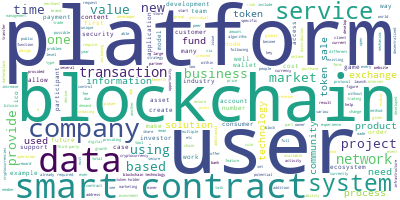

In [140]:
# Visualize the word cloud
wordcloud.to_image()

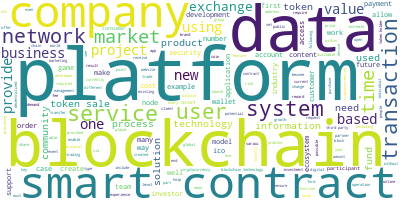

In [92]:
# Visualize the word cloud
wordcloud.to_image()

## Latent Dirichlet Allocation

### Remove punctuation

In [143]:
# Remove punctuation
df_only_wp['text_processed'] = df_only_wp['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df_only_wp['text_processed'] = df_only_wp['text_processed'].map(lambda x: x.lower())

## Tokenize words and further clean up text

In [144]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df_only_wp.text_processed.values.tolist()
data_words = list(sent_to_words(data))

## Phrase Modeling: Bigram and Trigram Models

In [145]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Remove Stopwords, Make Bigrams and Lemmatize

In [154]:
# NLTK Stop words
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['from', 'use','token','tokens','market','use','user',
                  'blockchain'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def keep_words(texts):
    corpus = []
    for doc in texts:
        text = nltk.pos_tag(doc)
        tag = []
        for t in text:
            if t[1] in ['NN','NNS','NNP','NNPS']:
                tag.append(t[0])
        corpus.append(tag)
    return corpus

In [155]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [156]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [157]:
data_lemmatized = keep_words(data_words_nostops)

In [158]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
## Check for faulty whitepaper
i=0
while i<=700:
    print('.............',i)
    print(data_words_nostops[i][70:90])
    time.sleep(1) # sleep for 20 seconds
    i=i+1

In [166]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=30,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [167]:
i=0
Topic = {}
while i<=29: 
    value = []
    for t in lda_model.show_topic(i,topn=20):
        value.append(t[0])
        Topic[i]=value
    i=i+1

In [168]:
# Word|Topic
Topic

{0: ['crypto',
  'cryptocurrency',
  'exchange',
  'payment',
  'bizpaye',
  'users',
  'currency',
  'platform',
  'transactions',
  'transaction',
  'trade',
  'services',
  'ecosystem',
  'technology',
  'paper',
  'wallet',
  'merchant',
  'exchanges',
  'industry',
  'merchants'],
 1: ['network',
  'chain',
  'transaction',
  'block',
  'transactions',
  'system',
  'nodes',
  'protocol',
  'data',
  'platform',
  'service',
  'time',
  'contract',
  'consensus',
  'users',
  'node',
  'value',
  'security',
  'ethereum',
  'systems'],
 2: ['fund',
  'investment',
  'capital',
  'companies',
  'investors',
  'ventures',
  'platform',
  'value',
  'technology',
  'portfolio',
  'swarm',
  'team',
  'company',
  'ltd',
  'pte',
  'vc',
  'funds',
  'venture',
  'business',
  'model'],
 3: ['data',
  'network',
  'system',
  'information',
  'contract',
  'users',
  'storage',
  'technology',
  'access',
  'time',
  'security',
  'contracts',
  'product',
  'process',
  'protocol',
 

In [174]:
test_doc = corpus[259]

vector = lda_model[test_doc]
print(vector[0])

[(0, 0.028859343), (3, 0.011328804), (10, 0.023439681), (15, 0.084122606), (16, 0.42948717), (17, 0.2788709), (21, 0.034316767), (24, 0.09351438)]
